In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import rotate
from skimage.util import montage
import json

from sklearn.preprocessing import MinMaxScaler

# Brain Tumour Dataset Information

## Dataset Overview

The dataset used in this project is the BRATS (Brain Tumor Segmentation) dataset. It is designed for the segmentation of gliomas, which are a type of brain tumor, and includes both tumor and edema regions.

- **Name**: BRATS
- **Description**: Gliomas segmentation tumour and oedema in on brain images
- **Reference**: [BRATS 2017](https://www.med.upenn.edu/sbia/brats2017.html)
- **License**: CC-BY-SA 4.0
- **Release Date**: 2.0 04/05/2018

## Dataset Properties

### Modalities

The dataset contains images captured in four modalities:

- **0**: FLAIR
- **1**: T1w
- **2**: t1gd
- **3**: T2w

These modalities provide different information useful for medical image analysis and can be retrieved from the last dimension of the `.nii` file.

### Labels

The dataset features four distinct labels for segmentation:

- **0**: background
- **1**: edema
- **2**: non-enhancing tumor
- **3**: enhancing tumour

These labels represent different anatomical structures or abnormalities in the brain, aiding in the identification and segmentation of brain tumors.

## Dataset Statistics

- **Number of training samples (with ground truth)**: 484
- **Number of test samples (without ground truth)**: 266

In the training samples there are two types of sick people:
- **Enhancing tumour samples**: 472
- **Non-enhancing tumour samples**: 12

The dataset is structured to include both training and test samples, with detailed annotations for each image.

In [80]:
TRAINING_DATA_PATH = "../BrainTumourData/imagesTr/"
TRAINING_LABEL_PATH = "../BrainTumourData/labelsTr/"

In [85]:
enhancing_counter = 0
non_enhancing_counter = 0

for label_file in os.listdir(TRAINING_LABEL_PATH):
    if label_file.endswith(".nii.gz"):
        label_path = os.path.join(TRAINING_LABEL_PATH, label_file)
        label_img = nib.load(label_path)
        label_data = label_img.get_fdata()

        if np.any(label_data > 2):
            enhancing_counter += 1
        else:
            non_enhancing_counter += 1

print(f"Enhancing tumour counter: {enhancing_counter}")
print(f"Non-enhancing tumour counter: {non_enhancing_counter}")

Enhancing tumour counter: 472
Non-enhancing tumour counter: 12


In [88]:
metadata_path = f"../BrainTumourData/dataset.json"
with open(metadata_path, "r") as file:
    data = json.load(file)

print("Dataset metadata:")
print("Name:", data["name"])
print("Description:", data["description"])
print("Reference:", data["reference"])
print("License:", data["licence"])
print("Release date:", data["release"])

print()
print("Dataset statistics:")
print("Modalities:", data["modality"])
print("Labels:", data["labels"])
print("Number of training samples (samples with output):", data["numTraining"])
print("Number of testing samples (samples without output):", data["numTest"])

Dataset metadata:
Name: BRATS
Description: Gliomas segmentation tumour and oedema in on brain images
Reference: https://www.med.upenn.edu/sbia/brats2017.html
License: CC-BY-SA 4.0
Release date: 2.0 04/05/2018

Dataset statistics:
Modalities: {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Labels: {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Number of training samples (samples with output): 484
Number of testing samples (samples without output): 266


In [77]:
# Load the .nii.gz file
image_number = "227"
file_path = f"{TRAINING_DATA_PATH}/BRATS_{image_number}.nii.gz"  # Replace with the actual file path
mask_path = f"{TRAINING_LABEL_PATH}/BRATS_{image_number}.nii.gz"  # Replace with the actual file path
img = nib.load(file_path)
mask = nib.load(mask_path)

print(".nii file Shape: ", img.shape)

# Get the image data as a NumPy array
data_flair = img.get_fdata()[:, :, :, 0]
data_t1w = img.get_fdata()[:, :, :, 1]
data_t1gd = img.get_fdata()[:, :, :, 2]
data_t2w = img.get_fdata()[:, :, :, 3]
data_mask = mask.get_fdata()

print("Shape: ", data_flair.shape)
print("Dtype: ", data_flair.dtype)

.nii file Shape:  (240, 240, 155, 4)
Shape:  (240, 240, 155)
Dtype:  float64


## Data Preprocessing with MinMaxScaler

### Why MinMaxScaler?

In medical image analysis, especially when dealing with MRI scans, the intensity values of the images can vary significantly. This variation can be due to different imaging protocols, scanners, or even patient-specific factors. To ensure that the data is on a common scale and to improve the performance of machine learning models, it is essential to normalize the intensity values.

### Application in Our Dataset

In our dataset, we apply the `MinMaxScaler` to the different MRI modalities (FLAIR, T1w, T1gd, T2w) to ensure that the intensity values are normalized. This step is crucial for the following reasons:

1. **Consistency**: Normalizing the data ensures that all images have a consistent range of intensity values, which is important for downstream processing and analysis.
2. **Model Performance**: Many machine learning algorithms perform better when the input data is normalized. It helps in faster convergence and can lead to better model performance.
3. **Comparability**: By scaling the data to a common range, it becomes easier to compare and combine images from different modalities.


In [42]:
print("Min: ", data_flair.min())
print("Max: ", data_flair.max())

Min:  0.0
Max:  2217.0


In [43]:
scaler = MinMaxScaler()

data_flair = scaler.fit_transform(data_flair.reshape(-1, data_flair.shape[-1])).reshape(
    data_flair.shape
)
data_t1w = scaler.fit_transform(data_t1w.reshape(-1, data_t1w.shape[-1])).reshape(
    data_t1w.shape
)
data_t1gd = scaler.fit_transform(data_t1gd.reshape(-1, data_t1gd.shape[-1])).reshape(
    data_t1gd.shape
)
data_t2w = scaler.fit_transform(data_t2w.reshape(-1, data_t2w.shape[-1])).reshape(
    data_t2w.shape
)

In [44]:
print("Min: ", data_flair.min())
print("Max: ", data_flair.max())

Min:  0.0
Max:  1.0


## Data Trimming

### Rationale for Trimming

We can remove elements that contain little to no information, which is often the case in medical imaging where the edges of the scan do not capture relevant anatomical structures. By trimming these elements, we can focus on the more informative central part of the images.

### Benefits of Trimming

1. **Improved Performance**: Reducing the size of the data by removing non-informative elements can lead to faster processing times and lower memory usage.
2. **Enhanced Model Training**: Machine learning models can train more efficiently on data that is free from irrelevant or redundant information.
3. **Better Visualization**: Visualizations become clearer and more focused on the regions of interest, aiding in better interpretation and analysis.

In our dataset, we have applied this trimming to all modalities (FLAIR, T1w, T1gd, T2w) and the corresponding masks.


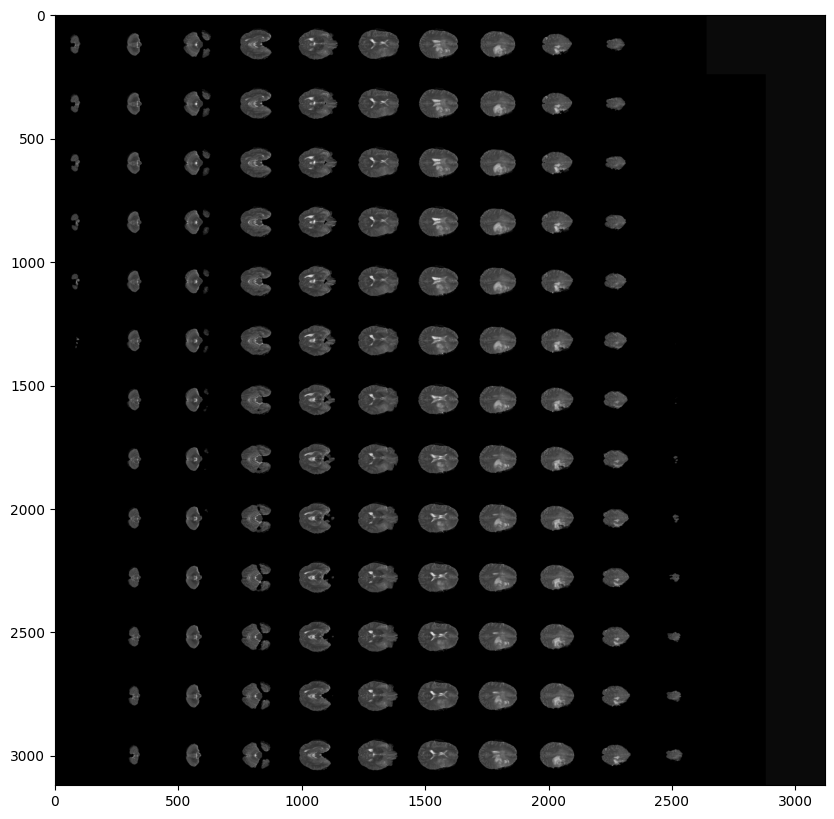

In [91]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(
    rotate(montage(np.swapaxes(data_t2w[:, :, :], 0, 2)), 90, resize=True), cmap="gray"
)

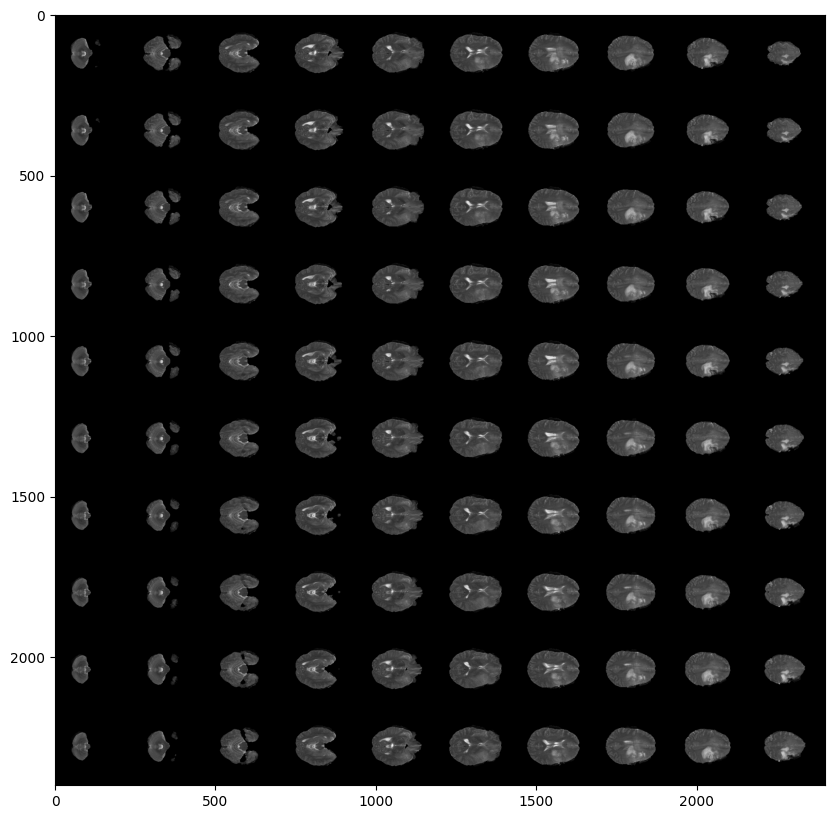

In [94]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(
    rotate(montage(np.swapaxes(data_t2w[:, :, 22:122], 0, 2)), 90, resize=True),
    cmap="gray",
)

In [47]:
data_flair = data_flair[50:-50, :, :]
data_t1w = data_t1w[50:-50, :, :]
data_t1gd = data_t1gd[50:-50, :, :]
data_t2w = data_t2w[50:-50, :, :]
data_mask = data_mask[50:-50, :, :]

### MRI Modalities

In our dataset, we have four different MRI modalities, each providing unique information about the brain's structure and pathology:

1. **FLAIR (Fluid-Attenuated Inversion Recovery)**

   - This modality is used to suppress the effects of fluid in the brain, making it easier to detect lesions. It is particularly useful for identifying edema and other abnormalities.

2. **T1w (T1-weighted Imaging)**

   - T1-weighted images provide high-resolution anatomical details of the brain. They are useful for visualizing the brain's structure and identifying abnormalities in the tissue.

3. **T1gd (T1-weighted Imaging with Gadolinium)**

   - This is a T1-weighted image taken after the administration of a gadolinium-based contrast agent. It helps to highlight areas with increased blood-brain barrier permeability, such as active tumors.

4. **T2w (T2-weighted Imaging)**
   - T2-weighted images are sensitive to water content and are useful for detecting edema and other fluid-related abnormalities. They provide a different contrast compared to T1-weighted images, making them complementary in diagnosis.

### Types of Views

In medical imaging, different views are used to visualize the brain from various angles. Here are the three primary types of views:

1. **Transverse View**

   - Also known as the axial view, this slice is taken horizontally through the brain, providing a top-down perspective. It is commonly used to assess the overall structure and detect abnormalities.

2. **Frontal View**

   - Also known as the coronal view, this slice is taken vertically from the front to the back of the brain. It provides a front-facing perspective, useful for examining the brain's symmetry and identifying lesions.

3. **Sagittal View**
   - This slice is taken vertically from side to side, providing a side view of the brain. It is particularly useful for assessing the brain's midline structures and identifying abnormalities that may not be visible in other views.


Slice Number: 95


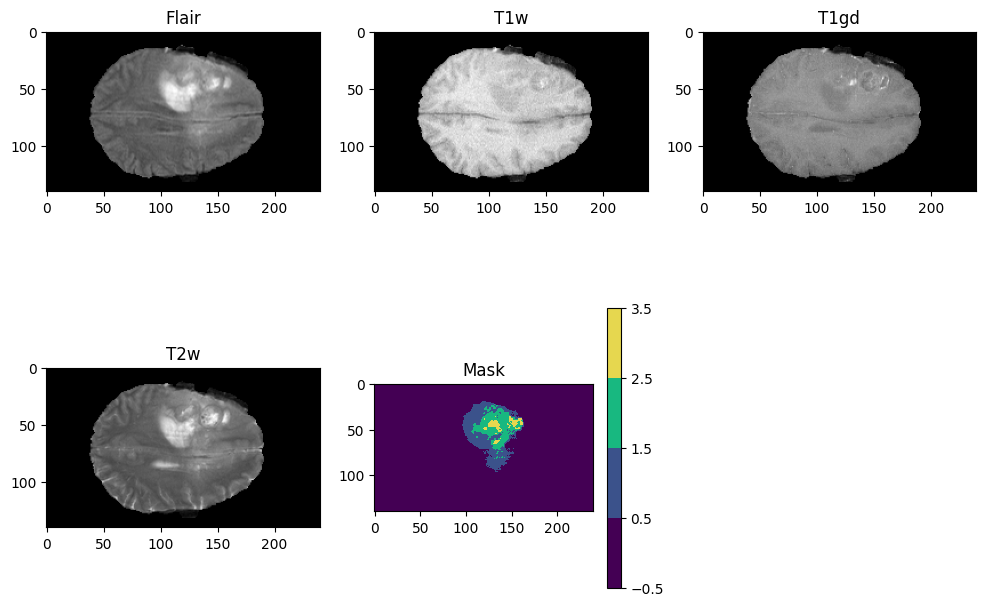

In [48]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# FLAIR
plt.subplot(2, 3, 1)
plt.imshow(data_flair[:, :, slice], cmap="gray")
plt.title("Flair")

# T1w
plt.subplot(2, 3, 2)
plt.imshow(data_t1w[:, :, slice], cmap="gray")
plt.title("T1w")

# t1gd
plt.subplot(2, 3, 3)
plt.imshow(data_t1gd[:, :, slice], cmap="gray")
plt.title("T1gd")

# T2w
plt.subplot(2, 3, 4)
plt.imshow(data_t2w[:, :, slice], cmap="gray")
plt.title("T2w")


# Mask
cmap = matplotlib.colors.ListedColormap(["#440054", "#3b528b", "#18b880", "#e6d74f"])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)
plt.subplot(2, 3, 5)
plt.imshow(data_mask[:, :, slice], cmap=cmap, norm=norm)
plt.colorbar()
plt.title("Mask")
plt.show()

Slice number: 95


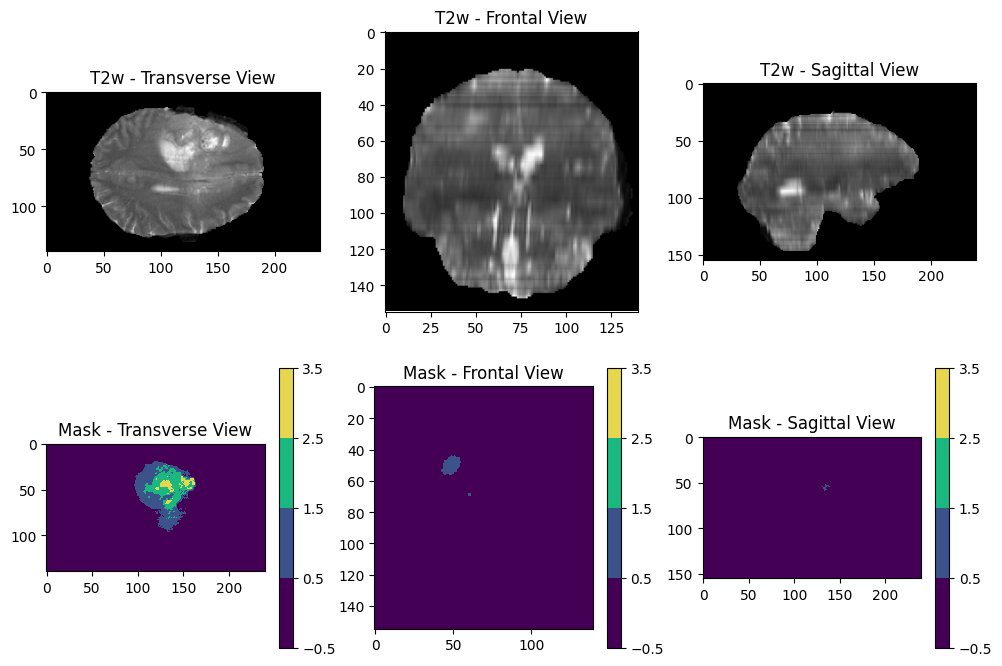

In [49]:
print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1gd - Transverse View
plt.subplot(2, 3, 1)
plt.imshow(data_t2w[:, :, slice], cmap="gray")
plt.title("T2w - Transverse View")

# T1gd - Frontal View
plt.subplot(2, 3, 2)
plt.imshow(rotate(data_t2w[:, slice, :], 90, resize=True), cmap="gray")
plt.title("T2w - Frontal View")

# T1gd - Sagittal View
plt.subplot(2, 3, 3)
plt.imshow(rotate(data_t2w[slice, :, :], 90, resize=True), cmap="gray")
plt.title("T2w - Sagittal View")

# Mask
cmap = matplotlib.colors.ListedColormap(["#440054", "#3b528b", "#18b880", "#e6d74f"])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.subplot(2, 3, 4)
plt.imshow(data_mask[:, :, slice], cmap=cmap, norm=norm)
plt.colorbar()
plt.title("Mask - Transverse View")

plt.subplot(2, 3, 5)
plt.imshow(rotate(data_mask[:, slice, :], 90, resize=True), cmap=cmap, norm=norm)
plt.colorbar()
plt.title("Mask - Frontal View")

plt.subplot(2, 3, 6)
plt.imshow(rotate(data_mask[slice, :, :], 90, resize=True), cmap=cmap, norm=norm)
plt.colorbar()
plt.title("Mask - Sagittal View")
plt.show()

### Segmentation Classes

In our dataset, the segmentation masks are divided into four distinct classes, each representing a different type of tissue or abnormality in the brain. These classes are crucial for understanding the structure and pathology of brain tumors. Here are the details of each class:

1. **Class 0: Background**

   - This class represents the non-tumor regions in the brain. It includes all the normal brain tissues and other structures that are not affected by the tumor.

2. **Class 1: Edema**

   - Edema refers to the swelling caused by the accumulation of fluid in the brain tissues. This class highlights the regions affected by edema, which is often associated with brain tumors.

3. **Class 2: Non-Enhancing Tumor**

   - This class represents the tumor regions that do not show enhancement after the administration of contrast agents. Non-enhancing tumors are typically less aggressive and have different characteristics compared to enhancing tumors.

4. **Class 3: Enhancing Tumor**
   - Enhancing tumors are the regions that show increased uptake of contrast agents, indicating a higher level of vascularity and aggressiveness. This class is crucial for identifying the most active and potentially dangerous parts of the tumor.

Understanding these classes helps in the accurate segmentation and analysis of brain tumors, aiding in diagnosis, treatment planning, and monitoring of disease progression.


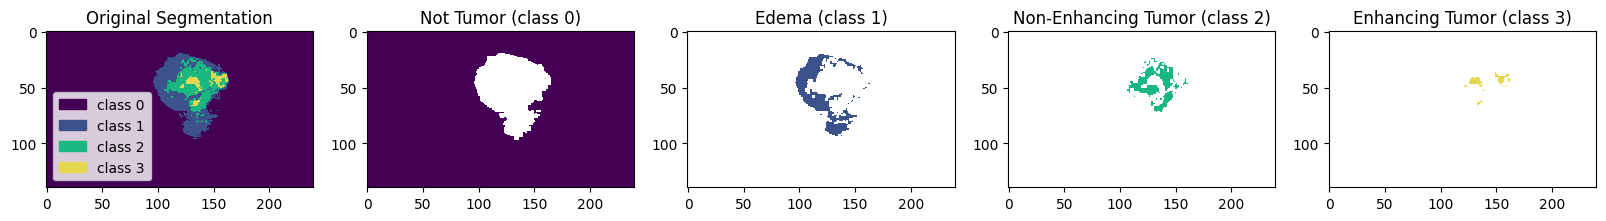

In [50]:
# Isolation of class 0
seg_0 = data_mask.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = data_mask.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = data_mask.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = data_mask.copy()
seg_3[seg_3 != 3] = np.nan

# Define legend
class_names = ["class 0", "class 1", "class 2", "class 3"]
legend = [
    plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i])
    for i in range(len(class_names))
]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(data_mask[:, :, slice], cmap=cmap, norm=norm)
ax[0].set_title("Original Segmentation")
ax[0].legend(handles=legend, loc="lower left")

ax[1].imshow(seg_0[:, :, slice], cmap=cmap, norm=norm)
ax[1].set_title("Not Tumor (class 0)")

ax[2].imshow(seg_1[:, :, slice], cmap=cmap, norm=norm)
ax[2].set_title("Edema (class 1)")

ax[3].imshow(seg_2[:, :, slice], cmap=cmap, norm=norm)
ax[3].set_title("Non-Enhancing Tumor (class 2)")

ax[4].imshow(seg_3[:, :, slice], cmap=cmap, norm=norm)
ax[4].set_title("Enhancing Tumor (class 3)")

plt.show()

## Data Exploration Summary

- **Dataset Information:**
    - **Name:** BRATS
    - **Description:** Gliomas segmentation tumour and oedema in on brain images
    - **Reference:** [BRATS 2017](https://www.med.upenn.edu/sbia/brats2017.html)
    - **License:** CC-BY-SA 4.0
    - **Release Date:** 2.0 04/05/2018

- **Dataset Properties:**
    - **Modalities:**
        - 0: FLAIR
        - 1: T1w
        - 2: t1gd
        - 3: T2w
    - **Labels:**
        - 0: background
        - 1: edema
        - 2: non-enhancing tumor
        - 3: enhancing tumour

- **Dataset Statistics:**
    - **Number of training samples (with ground truth):** 484
    - **Number of test samples (without ground truth):** 266
    - **Enhancing tumour samples:** 472
    - **Non-enhancing tumour samples:** 12

- **Data Loading and Preprocessing:**
    - Loaded image and mask data from `.nii.gz` files.
    - Extracted different modalities (FLAIR, T1w, t1gd, T2w) from the image data.
    - Applied MinMaxScaler to normalize the data.

- **Data Visualization:**
    - Displayed various slices of the brain images in different modalities.
    - Visualized the segmentation masks with distinct colors for each class.
    - Created transverse, frontal, and sagittal views of the T2w modality and corresponding masks.

- **Segmentation Analysis:**
    - Isolated different classes (background, edema, non-enhancing tumor, enhancing tumor) from the segmentation mask.
    - Displayed the isolated classes alongside the original segmentation for comparison.